In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
df.drop('id', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [3]:
num_cols = df.select_dtypes(include=['number']).columns.difference(['y'])
cat_cols = df.select_dtypes(include=['object']).columns

In [14]:
num_cols

Index(['age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous'], dtype='object')

In [4]:
import warnings
warnings.filterwarnings('ignore')

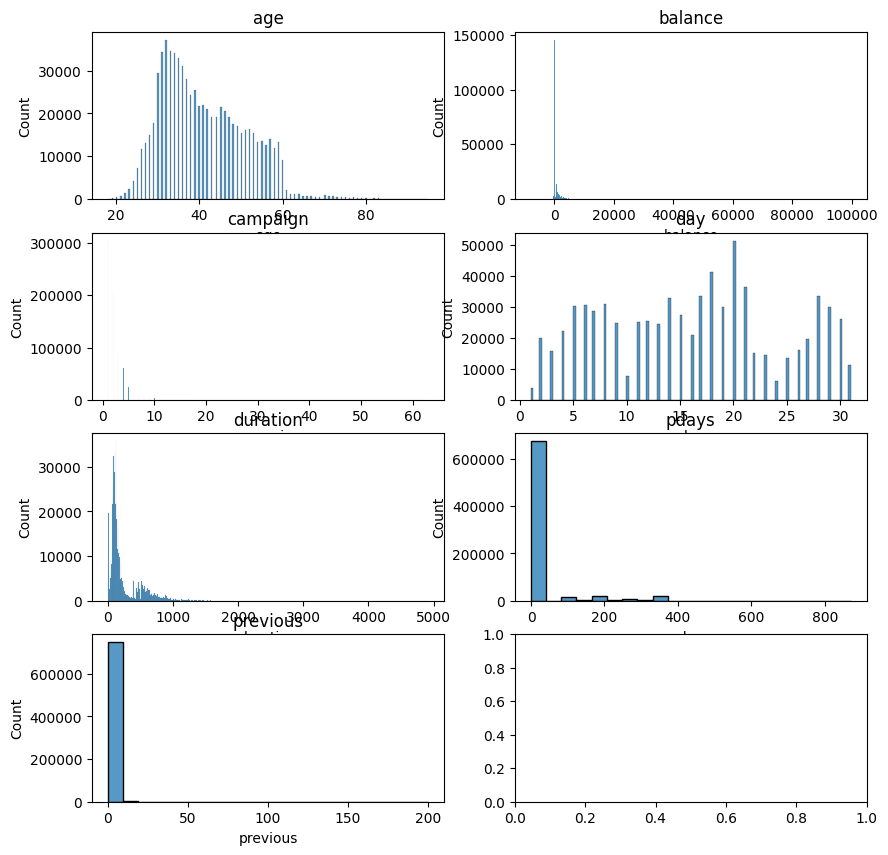

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(col)
plt.show()

In [20]:
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

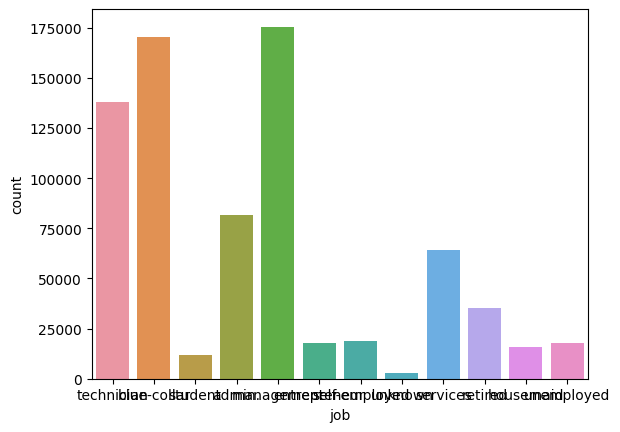

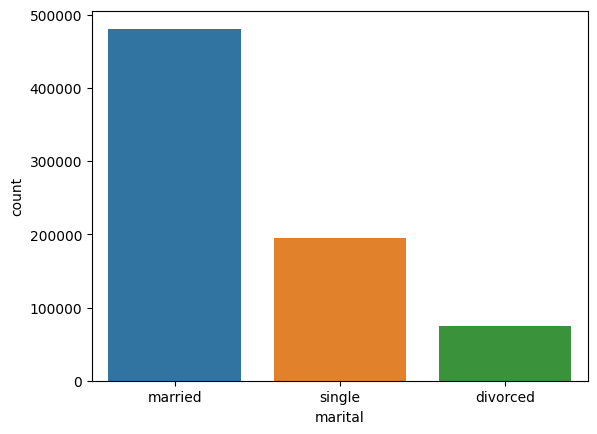

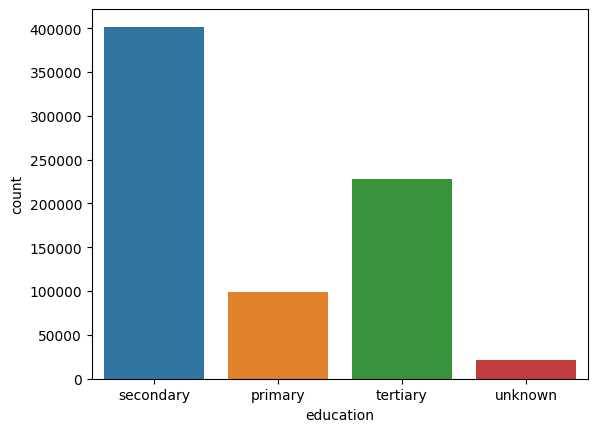

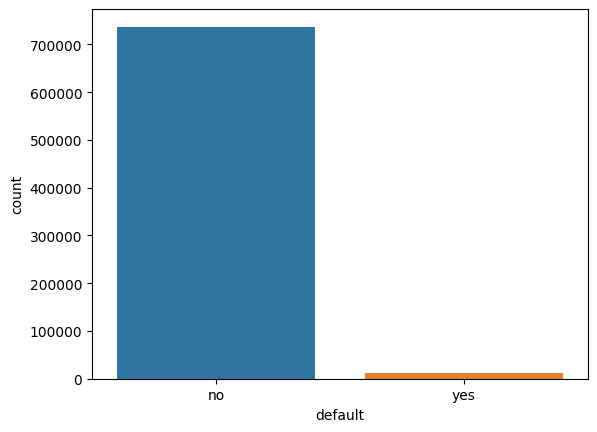

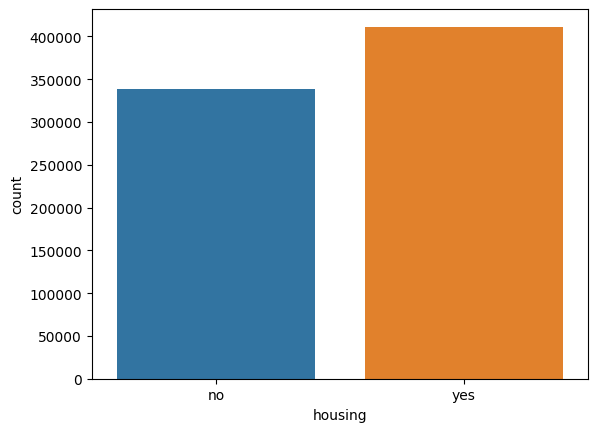

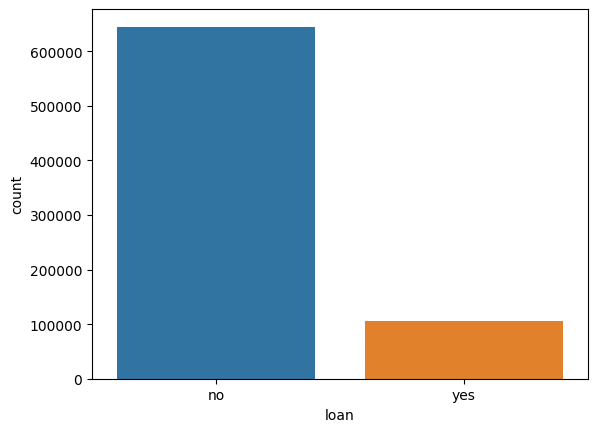

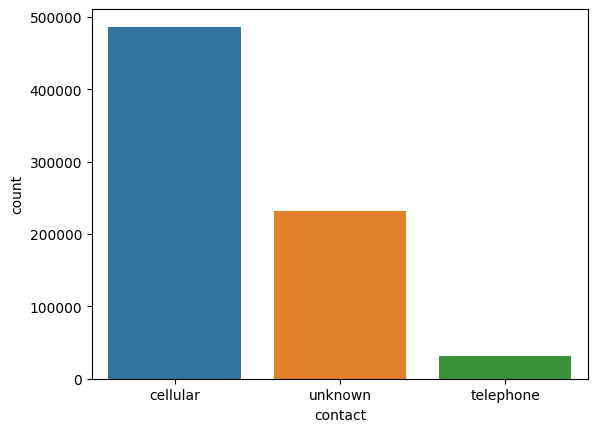

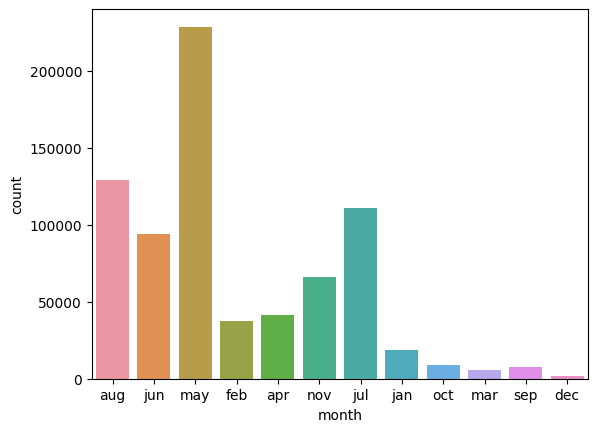

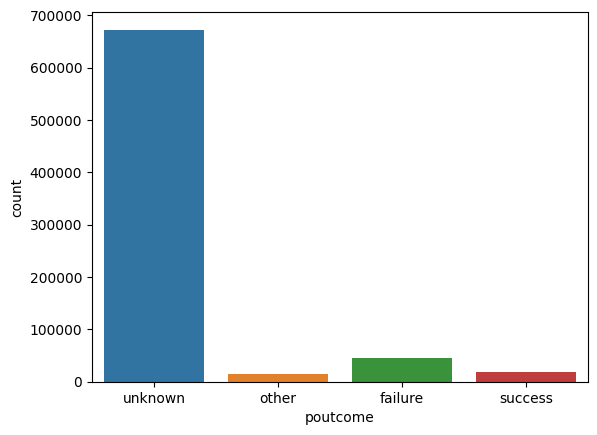

In [22]:
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col)
    plt.show()

In [5]:
for col in cat_cols:
    df[col] = df[col].astype('category')
df[cat_cols] = df[cat_cols].replace('unknown', np.nan)

In [42]:
df[cat_cols].isna().sum()

job            2917
marital           0
education     21299
default           0
housing           0
loan              0
contact      231627
month             0
poutcome     672450
dtype: int64

In [43]:
df['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x792ad476e1d0>,
 [Text(-1.0219242770505947, 0.4070267460187593, '0'),
  Text(1.0219242961048904, -0.4070266981790315, '1')],
 [Text(-0.557413242027597, 0.22201458873750507, '87.9%'),
  Text(0.5574132524208493, -0.22201456264310807, '12.1%')])

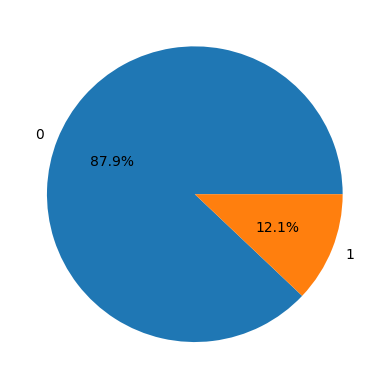

In [34]:
plt.pie(df['y'].value_counts().values, labels=df['y'].value_counts().index, autopct='%1.1f%%')

In [7]:
X = df.drop('y', axis=1)
y = df['y']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
train_data = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'scale_pos_weight': 7.28839
}

model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 72283, number of negative: 527717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120472 -> initscore=-1.987971
[LightGBM] [Info] Start training from score -1.987971


In [10]:
y_pred = model.predict(X_test)

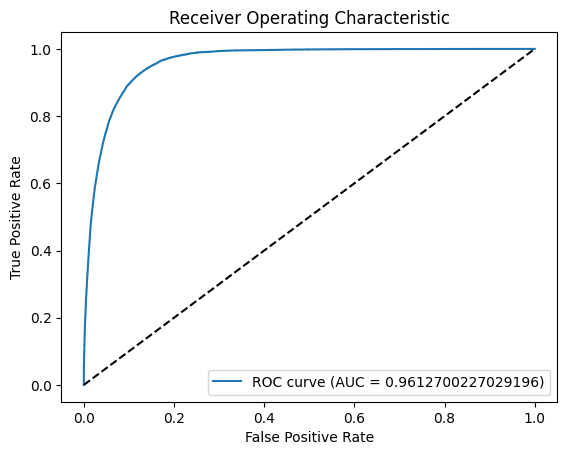

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')  #
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

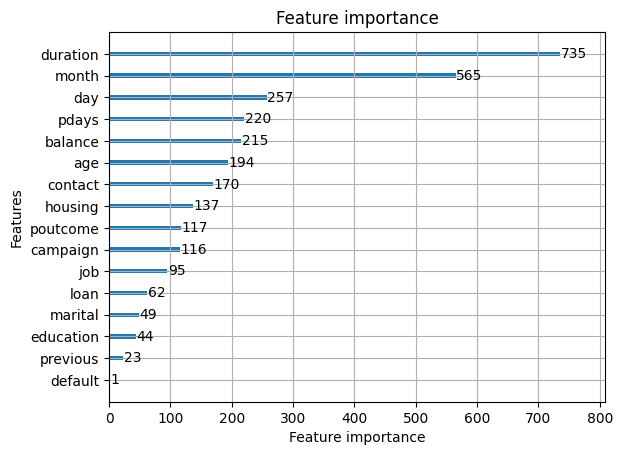

In [55]:
lgb.plot_importance(model, max_num_features=20)

In [12]:
from bayes_opt import BayesianOptimization

def lgb_optimizer(num_leaves, learning_rate, max_depth, min_data_in_leaf, feature_fraction, lambda_l1, lambda_l2):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'verbose': -1
    }
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        metrics='auc',
        seed=42
    )
    
    # Check the actual key in cv_results (try printing cv_results.keys())
    # Common keys: 'auc-mean', 'valid auc-mean', 'binary_logloss-mean', etc.
    auc_key = [key for key in cv_results.keys() if 'auc' in key and 'mean' in key][0]
    return max(cv_results[auc_key])  # Return the best AUC score

# Define parameter bounds
pbounds = {
    'num_leaves': (15, 127),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 12),
    'min_data_in_leaf': (20, 100),
    'feature_fraction': (0.7, 1.0),
    'lambda_l1': (0, 100),
    'lambda_l2': (0, 100)
}

# Run Bayesian optimization
optimizer = BayesianOptimization(f=lgb_optimizer, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)  
print("Best parameters:", optimizer.max['params'])

|   iter    |  target   | num_le... | learni... | max_depth | min_da... | featur... | lambda_l1 | lambda_l2 |
-------------------------------------------------------------------------------------------------------------
| 2         | 0.9670318 | 56.948493 | 0.2857071 | 9.5879454 | 67.892678 | 0.7468055 | 15.599452 | 5.8083612 |
| 3         | 0.9644550 | 112.01172 | 0.1843233 | 9.3726532 | 21.646759 | 0.9909729 | 83.244264 | 21.233911 |
| 4         | 0.9589349 | 35.364396 | 0.0631873 | 5.7381801 | 61.980514 | 0.8295835 | 29.122914 | 61.185289 |
| 5         | 0.9623438 | 30.623312 | 0.0947219 | 6.2972565 | 56.485598 | 0.9355527 | 19.967378 | 51.423443 |
| 6         | 0.9575978 | 81.350431 | 0.0234706 | 8.4679036 | 33.641929 | 0.7195154 | 94.888553 | 96.563203 |
| 7         | 0.9563535 | 105.54050 | 0.0983379 | 3.8790490 | 74.738642 | 0.8320457 | 12.203823 | 49.517691 |
| 8         | 0.9636630 | 18.851514 | 0.2737029 | 5.3290198 | 73.001782 | 0.7935133 | 52.006802 | 54.671027 |
| 9       

In [20]:
best_params = {'num_leaves': 57, 
              'learning_rate': 0.28570714885887566, 
              'max_depth': 10, 
              'min_data_in_leaf': 68, 
              'feature_fraction': 0.7468055921327309, 
              'lambda_l1': 15.599452033620265, 
              'lambda_l2': 5.8083612168199465}

model = lgb.train(
    best_params,
    train_data,
    num_boost_round=100,
)

In [21]:
y_pred = model.predict(X_test)

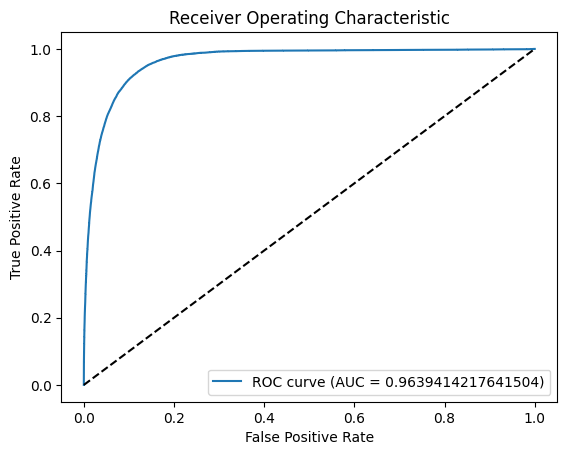

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')  #
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [23]:
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [28]:
X_test = test_df.drop('id', axis=1)
cat_cols = X_test.select_dtypes(include=['object']).columns
for col in cat_cols:
    X_test[col] = X_test[col].astype('category')
X_test[cat_cols] = X_test[cat_cols].replace('unknown', np.nan)
y_pred = model.predict(X_test)

In [29]:
submission = pd.DataFrame({"id": test_df["id"], "y": y_pred})
submission.to_csv("submission_bank.csv", index=False)